# Clasificación en dataset Banknote Authentication
En el siguiente notebook realizaremos un pipeline para clasificar distintos documentos bancarios. Cada registro/instancia/sample tiene 4 caracteristicas/features/dimensiones y son:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 

El dataset fue obtenido de https://archive.ics.uci.edu/ml/datasets/banknote+authentication

Importar las librerias que venimos usando siempre.

In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importamos librerias de scikit-learn

In [2]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Importamos dataset de Wisconsin Breast Cancer

In [3]:
banknotes = pd.read_csv('clusterai2019_clase03_dataset_banknote_authentication.txt', delimiter=',', header= None)

Visualizamos el dataset. Observamos que en la columna "diagnosis" se encuentra si el tumor es benigno o maligno. El resto de las columnas refiere a distintas features del tumor. Ver que la primer columna es el ID del paciente, esta información no nos interesa!!

In [ ]:
# observamos que de las 5 columnas 4 son para features y la ultima para las etiquetas de cada muestra.
banknotes.head()

# Reviso que no existan valores nulos en mi dataset

In [ ]:
banknotes.isnull().any()

# Separo mi variable independiente X

Vamos a guardar en una variable llamada "x" las features asociadas a cada muestra. Esta matriz contendra la informacion predictora del problema.

Inicialmente vamos a crear "x" solamente utilizando las features desde la columna 0 a la 3 inclusive. En el "iloc" tendremos dos indicadores:
- El primero de los renglones. Indicamos con ":" que queremos todos los renglones.
- En el segundo espacio indicamos "0:-1" y es una manera rapida de indicarle que queremos desde la primer columna "0" hasta hasta la anteúltima columna es poniendo un "-1".

In [4]:
# declaramos la matriz con variables independientes.
x = banknotes.iloc[:,0:-1]

In [5]:
x.head()

,0,1,2,3
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


In [6]:
print("El dataset tiene " +str(x.shape[0]) + " instancias y " + str(x.shape[1]) + " dimensiones")

El dataset tiene 1372 instancias y 4 dimensiones


Con un Pairplot vamos a visualizar como se relacionan par-a-par las variables seleccionadas a lo largo de todo el dataset.

In [ ]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.pairplot(x)
plt.show()

¿que conclusiones podemos obtener del pairplot? Podemos tambien hacer un heatmap de una matriz de correlación sobre las features de la matrix X y entender si correlacionan o no linealmente.

In [ ]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(x.corr())
plt.title("Correlación Lineal de pearson entre features")
plt.show()

# Separo mi variable dependiente Y

Ahora procederemos a crear el vector de etiquetas con las variables dependientes. Ver que las etiquetas se encuentran en la última columna (es decir la columna 4 o la columna "-1" es lo mismo) del dataset.

In [7]:
y = banknotes.iloc[:,-1]

In [8]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 4, dtype: int64

Como nuestro vector de etiquetas "y" ya tiene las etiquetas en formato numérico en vez de palabras, no es necesario transformarlas con un label encoder y podemos usarlas asi tal como estan.

## Separo mi dataset en Train y Test
Con la funcion "train_test_split" de sklearn separaremos nuestro dataset (tanto x como y) en dos sets de entrenamiento y prueba independiente. Podemos elegir que % de muestras esten en cada conjunto. El random_state sirve para que pueda reproducirse la "aleatoriedad" de division de muestras en el futuro. 

In [9]:
# obtenemos xtrain, xtest, ytrain e ytest :) 
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4)

In [10]:
# observamos como queda la matriz de xtrain
xtrain.shape

(1097, 4)

In [11]:
# observamos como queda la matriz de xtest
xtest.shape

(275, 4)

## Auto-Scaling utilizando muestras de train 
Queremos dejar todas las features en los mismos rangos por eso utilizaremos el standard scaler para que queden con media 0 y desvio standard 1.

In [12]:
# auto scaling train- set (mean = 0, std = 1)
# ver que en la misma linea creamos el standard scaler y lo "fiteamos" al mismo tiempo con "xtrain"
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
# xtrain_scal tendra el dataset de train pre-procesado con el standard scaler
xtrain_scal = scaler.transform(xtrain)  
# para cada feature imprimimos la media y el desvio standard obtenido. Ver que media = 0 y stdev = 1.
print(xtrain_scal.mean(axis=0))
print(xtrain_scal.std(axis=0))

[ 9.71571653e-18  9.71571653e-18 -6.47714436e-18 -9.39185931e-17]
[1. 1. 1. 1.]


In [14]:
# utilizando el scaler "fiteado" o "ajustado" a los datos de train, aplicamos el scaler a los datos de test.
# obtenemos "xtest_scal" 
xtest_scal = scaler.transform(xtest)  
# obviamente la media y stdev de las features en test no seran 0 y 1 ya que el scaler se ajusto con train unicamente.
print(xtest_scal.mean(axis=0))
print(xtest_scal.std(axis=0))

[ 0.02624883 -0.05034337  0.0411328   0.01273283]
[0.97128438 1.00940807 1.03245123 0.99150343]


# Entrenar un modelo de Logistic Regression

In [22]:
# importamos desde scikit learn el modelo logistic regression
from sklearn.linear_model import LogisticRegression

In [23]:
# definimos el modelo LR bajo el nombre "lr_model"
lr_model = LogisticRegression(random_state=0, solver='lbfgs')

Indicamos una grilla de parametros para que se prueben en el gridsearchcv. Los parametros de cada modelo los podes ver desde la documentacion https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.


En este caso unicamente definimos una grilla del parametro "C" que funciona para "permitir" falsos positivos en el entrenamiento. Es decir, si C es bajo entonces permitimos que en el entrenamiento queden muestras mal clasificadas. Por el contrario, si C es alto le indicamos al modelo que queremos la menor cantidad de mal-clasificados posibles.

In [24]:
params_lr = {'C':[1, 10, 100]}

Definimos el gridsearchcv indicando el modelo, la grilla de parametros y la cantidad de "folds" de cross validation, en este caso 5.

In [25]:
lr_cv = GridSearchCV(lr_model, param_grid = params_lr, refit = True, cv = 5)

Con .fit() entrenamos el modelo, es decir, lo ajustamos a los datos de entrenamiento para minimizar el error de clasificación, o en otras palabras para maximizar la exactitud de clasificación (accuracy).

In [26]:
lr_cv.fit(xtrain_scal, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'C': [1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Una vez entrenado el modelo, podemos preguntarle al "lr_cv" cual es el mejor parametro de la grilla que le pasamos.

In [27]:
lr_cv.best_params_

{'C': 100}

Con el modelo entrenado podemos saber como resultó la clasificación en los datos de entrenamiento.

In [28]:
ypred_train_lr = lr_cv.predict(xtrain_scal)
ypred_train_lr

array([0, 1, 0, ..., 0, 0, 1])

Con la predicción en el entrenamiento podemos calcular el accuracy de train:

In [29]:
train_acc_lr = accuracy_score(ytrain, ypred_train_lr)
train_acc_lr

0.9881494986326345

Ahora podemos probar el modelo con datos de test (obviamente el predict siempre es sin la label).

In [30]:
# realizamos predicciones de Y utilizando los datos X de test con el modelo ya entrenado.
ypred_lr = lr_cv.predict(xtest_scal)

In [31]:
# calculamos el accuracy entre las etiquetas ya existentes y las que predijo nuestro modelo en datos de test independientes.
test_acc_lr = accuracy_score(ytest, ypred_lr)

In [32]:
print("La exactitud (accuracy) en test de clasificación utilizando Logistic Regression es de = " +str(np.round(test_acc_lr,3)))

La exactitud (accuracy) en test de clasificación utilizando Logistic Regression es de = 0.996


Podemos visualizar y evaluar los resultados con la matriz de confusion con la prediccion y etiquetas reales de test.

In [33]:
cm_lr = confusion_matrix(ytest, ypred_lr)

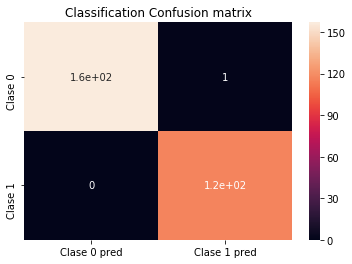

In [34]:
df_cm = pd.DataFrame(cm_lr, index = ['Clase 0', 'Clase 1'], columns = ['Clase 0 pred', 'Clase 1 pred'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

Tambien podemos calcular el area debajo de la curva ROC para evaluar como es la relacion entre True Positive y False Positive para distintos "umbrales" de clasificación.

In [35]:
#compute and plot AUC
yproba_lr = lr_cv.predict_proba(xtest_scal)
fpr_lr, tpr_lr, thresholds = roc_curve(ytest.astype('int'), yproba_lr[:,1], drop_intermediate = False)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
print("El AUC es = " + str(auc_lr))

El AUC es = 0.9999459050091961


Imprimimos en pantalla el area debajo de la curva con un plot

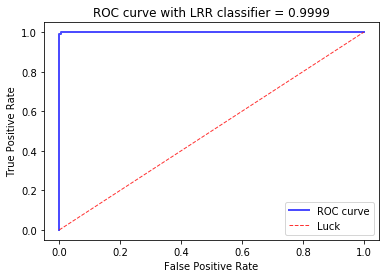

In [36]:
plt.plot(fpr_lr, tpr_lr, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC curve with LRR classifier = '+str(np.round(auc_lr,4)))
plt.show()

## Entrenar modelo KNN

Defino modelo KNN

In [37]:
# defino modelo KNN llamado "neigh"sin definir ningun hiperparametro
neigh = KNeighborsClassifier()

Defino la lista de valores del hiperparametro que quiero probar con gridsearchCV

In [38]:
params_knn = {'n_neighbors':[1,5,10,20]}

Defino un modelo con gridsearchCV, sus parametros y la cantidad de folds de cross validation.

In [39]:
# Ajusto mi modelo a las muestras de training utilizando tanto Xtrain como Ytrain
knn_cv = GridSearchCV(neigh, param_grid = params_knn, refit = True, cv = 5)

# Tarea 01: 
Entrenar un modelo KNN con gridsearchCV para entrenar el dataset definido anteriormente. Calcular todas las metricas de evaluación de clasificación.

In [40]:
#Entrenamos el modelo con xtrain_scal
knn_cv.fit(xtrain_scal, ytrain.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
#Busco los mejores parámetros
print("The best parameters are %s with a score of %0.2f" % (knn_cv.best_params_, knn_cv.best_score_))

The best parameters are {'n_neighbors': 10} with a score of 1.00


In [42]:
#Predecir labels para xtest_scal
predictionsknn=knn_cv.predict(xtest_scal) 
print(predictionsknn)

[0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1
 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1
 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1
 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0
 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1]


In [43]:
#Medimos el accuracy
scoreknn = knn_cv.score(xtest_scal,ytest.ravel())
print(scoreknn)

1.0


In [44]:
#Confusion Matrix
cm_knn = confusion_matrix(ytest, predictionsknn)
cm_knn

array([[158,   0],
       [  0, 117]])

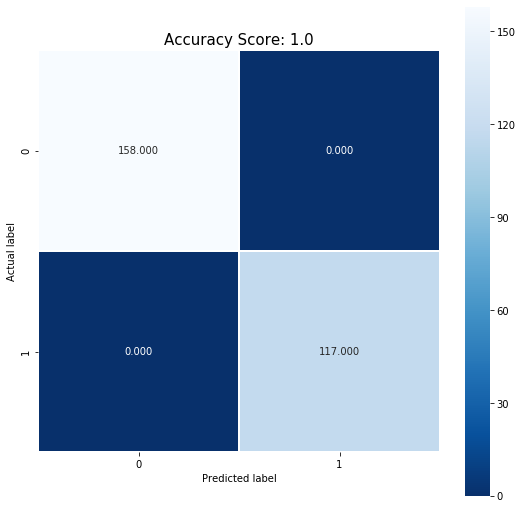

In [45]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_knn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(scoreknn)
plt.title(all_sample_title, size = 15);

In [46]:
#AUC ROC
yproba_knn = knn_cv.predict_proba(xtest_scal)
fpr_knn, tpr_knn, thresholds = roc_curve(ytest.astype('int'), yproba_knn[:,1], drop_intermediate = False)
auc = metrics.auc(fpr_knn, tpr_knn)
print("El AUC es = " + str(auc))

El AUC es = 1.0


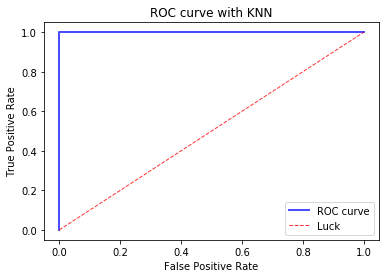

In [47]:
#Imprimo el AUC ROC
plt.plot(fpr_knn, tpr_knn, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC curve with KNN')
plt.show()

# Tarea 02: 
Entrenar un modelo SVM con grid search y cross validation cv = 5 utilizando el dataset definido anteriormente. Tambien definir el valor de los hiperparametros a probar en el gridsearchCV.

In [15]:
#Importamos modelo
from sklearn import svm
from sklearn.svm import SVC

In [50]:
#Entrenamos el modelo
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], 'gamma':[0.0001,0.001]}
svc = svm.SVC(probability=True)
svm_cv = GridSearchCV(svc, param_grid = parameters, refit = True, cv = 5)
svm_cv.fit(xtrain_scal, ytrain.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.0001, 0.001],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [51]:
print("The best parameters are %s with a score of %0.2f" % (svm_cv.best_params_, svm_cv.best_score_))

The best parameters are {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'} with a score of 0.99


In [52]:
#Predecir labels para xtest_scal
predictionsSVM=svm_cv.predict(xtest_scal) 
print(predictionsSVM)

[0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1
 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1
 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1
 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0
 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1]


In [53]:
#Medimos el accuracy
scoresvm=svm_cv.score(xtest_scal,ytest.ravel())
print(scoresvm)

0.9963636363636363


In [54]:
#Confusion Matrix
cm_svm = confusion_matrix(ytest, predictionsSVM)
cm_svm

array([[157,   1],
       [  0, 117]])

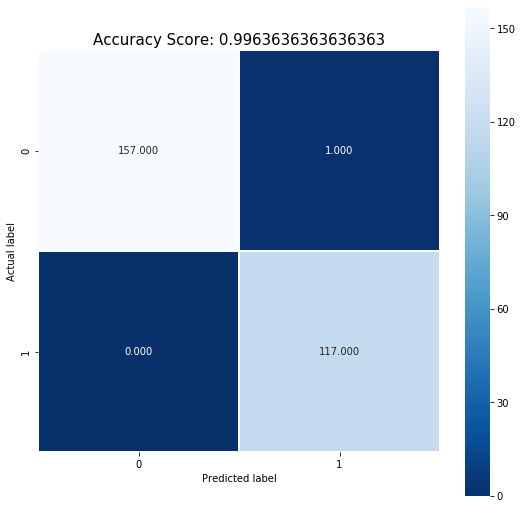

In [55]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_svm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(scoresvm)
plt.title(all_sample_title, size = 15);

In [56]:
#Computamos el AUC ROC
yproba_svm = svm_cv.predict_proba(xtest_scal)
fpr_svm, tpr_svm, thresholds = roc_curve(ytest.astype('int'), yproba_svm[:,1])
auc = metrics.auc(fpr_svm, tpr_svm)
print("El AUC es = " + str(auc))

El AUC es = 0.9998377150275883


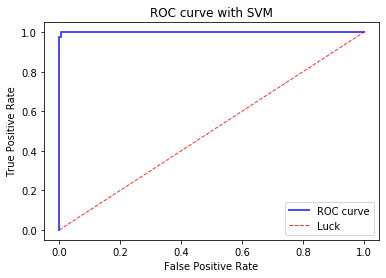

In [57]:
#Imprimo el AUC ROC
plt.plot(fpr_svm, tpr_svm, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC curve with SVM')
plt.show()